# Jupyter Notebook for Data Visualization of HTS 2025 Paper Datasets
## Author: Anish Vasan
## Date: 2025/08/08

## Notebook Setup

### Imports

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots

In [26]:
plt.style.use(['science', 'nature'])
plot_params = {
    "figure.dpi": "200",
    "axes.labelsize": 14,
    "axes.linewidth": 1.5,
    "axes.titlesize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.title_fontsize": 16,
    "legend.fontsize": 16,
    "xtick.major.size": 3.5,
    "xtick.major.width": 1.5,
    "xtick.minor.size": 2.5,
    "xtick.minor.width": 1.5,
    "ytick.major.size": 3.5,
    "ytick.major.width": 1.5,
    "ytick.minor.size": 2.5,
    "ytick.minor.width": 1.5,
}
plt.rcParams.update(plot_params)

sns.set_style("ticks")

### Functions

#### Data Preparation Functions

In [27]:
def process_excel_files(file_name_fn, file_path_fn)->dict:
    """Process a list of Excel files generate DataFrames."""
    print(f"Processing file: {file_path_fn}")
    data = pd.read_excel(file_path_fn, sheet_name=None)

    # Load required sheets, dropping unnecessary columns
    condition_map = data['condition_map']
    is_broken = data['is_broken'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    is_closed = data['is_closed'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    wound_area = data['wound_area'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    wound_minor_axis_length = data['wound_minor_axis_length'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    wound_major_axis_length = data['wound_major_axis_length'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    # import multi-index df for pillars
    relative_pillar_distances = pd.read_excel(file_path_fn, sheet_name='relative_pillar_distances', header=1)
    relative_pillar_distances = relative_pillar_distances.drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    relative_pillar_distances = relative_pillar_distances.stack().str.split(' ', expand=True).unstack()
    relative_pillar_distances = relative_pillar_distances.dropna(axis=1, how='all')
    relative_pillar_distances = relative_pillar_distances.astype(float)

    # Extract time index
    time_index = data['wound_area']['Time']

    # Filter wound area data based on is_broken and is_closed
    wound_area_filtered, columns_to_drop = filter_wound_area(wound_area, is_broken, is_closed)

    # Drop the columns in wound_minor_axis_length, major_axis_length, and relative_pillar_distances (second level header) that were dropped from wound_area_filtered
    if not columns_to_drop:
        print("No columns were dropped during filtering.")
    else:
        print(f"Dropping columns from other parameters")
    wound_minor_axis_length = wound_minor_axis_length.drop(columns=columns_to_drop)
    wound_major_axis_length = wound_major_axis_length.drop(columns=columns_to_drop)
    #relative_pillar_distances = relative_pillar_distances.drop(columns=columns_to_drop, level=1)

    # Identify outliers based on major and minor axis lengths at time 0
    outlier_wells, bounds = identify_outliers(
        wound_minor_axis_length.iloc[0], wound_major_axis_length.iloc[0]
    )
    print(f"Wells outside bounds for {file_name_fn}: \n{[key for key in outlier_wells.keys()]}")
    # Plot wound axis lengths
    plot_wound_axis_lengths(
        wound_major_axis_length.iloc[0],
        wound_minor_axis_length.iloc[0],
        bounds, outlier_wells, file_name_fn
    )

    # Create condition dictionary
    dict_conditions = create_dict_condition(condition_map, wound_area_filtered)

    # Normalize wound area data
    wound_area_normalized = normalize_wound_area(wound_area_filtered)

    # Return processed data
    return {
        'dict_condition': dict_conditions,
        'wound_area_filtered': wound_area_filtered,
        'wound_area_normalized': wound_area_normalized,
        'wound_minor_axis_length': wound_minor_axis_length,
        'wound_major_axis_length': wound_major_axis_length,
        'outlier_wells': outlier_wells,
        'time_index': time_index,
        'relative_pillar_distances': relative_pillar_distances
    }

def filter_wound_area(wound_area_input, is_broken_input, is_closed_input)->tuple:
    """Filter the wound_area DataFrame based on is_broken and is_closed."""

    # Drop columns where is_broken=1 before is_closed=1 or if the first is_broken=1
    columns_to_drop = []
    for col in is_broken_input.columns:
        if col in wound_area_input.columns:

            # Check if the first value of is_broken is 1
            if is_broken_input[col].iloc[0] == 1:
                if col not in columns_to_drop:
                    columns_to_drop.append(col)

            # Find first index where is_broken is 1
            broken_indices = is_broken_input[col][is_broken_input[col] == 1].index
            # Find first index where is_closed is 1
            closed_indices = is_closed_input[col][is_closed_input[col] == 1].index

            if not broken_indices.empty:
                first_broken = broken_indices[0]
                if closed_indices.empty or first_broken < closed_indices[0]:
                    columns_to_drop.append(col)

    # Print the columns that will be dropped
    print("Columns dropped due to is_broken condition:", columns_to_drop)
    # Drop the columns from wound_area
    wound_area_filtered_fn = wound_area_input.drop(columns=columns_to_drop)
    columns_to_drop_output = columns_to_drop.copy()  # Store the columns to drop for later use

    # Now filter based on is_closed=1
    # Reset the wound_area_filtered_fn to the current filtered state
    columns_to_drop = []
    # Set values to 0 where is_closed is 1
    for col in is_closed_input.columns:
        if col in wound_area_filtered_fn.columns:
            wound_area_filtered_fn[col] = np.where(is_closed_input[col] == 1, 0, wound_area_filtered_fn[col])
            # Append the column to columns_to_drop if the first value is 0 (this assumes that if the first value is 0, the tissue was not injured and no injury was segmented)
            if wound_area_filtered_fn[col].iloc[0] == 0:
                columns_to_drop.append(col)

    # Print the columns that will be dropped due to is_closed and is_broken conditions
    print("Columns dropped due to is_closed[0]=0 condition:", columns_to_drop)
    # Drop the columns from wound_area
    wound_area_filtered_output = wound_area_filtered_fn.drop(columns=columns_to_drop)
    print('Dropped')
    columns_to_drop_output.extend(columns_to_drop)
    print(columns_to_drop_output)
    return wound_area_filtered_output, columns_to_drop_output

def create_dict_condition(condition_map_input, wound_area_filtered_input)->dict:
    """Create a dictionary of conditions and their corresponding wells."""
    dict_condition_fn = {}
    for index, row in condition_map_input.iterrows():
        condition_name = row['Condition_Name']
        well_name_fn = row['Well']

        # Check if the well name exists in wound_area_filtered columns
        waf_column_split = [col.split('_')[1] for col in wound_area_filtered_input.columns]
        if well_name_fn in waf_column_split:
            # Get the full column name that contains the well name
            full_well_name = [col for col in wound_area_filtered_input.columns if col.split('_')[1] == well_name_fn][0]
            if condition_name not in dict_condition_fn:
                dict_condition_fn[condition_name] = []
            dict_condition_fn[condition_name].append(full_well_name)
    return dict_condition_fn

def combine_conditions(extracted_data_input)->tuple:
    """Combine conditions from processed data into a single dictionary with DataFrames."""
    dict_combined_condition_fn = {}
    dict_counter = {}
    for file_name, data_fn in extracted_data_input.items():
        condition_dict_fn = data_fn['dict_condition']
        wound_area_normalized_fn = data_fn['wound_area_normalized']
        relative_pillar_distance_fn = data_fn['relative_pillar_distances']

        for condition_fn, wells in condition_dict_fn.items():
            if condition_fn not in dict_combined_condition_fn:
                # Initialize with the first file's data for this condition
                dict_combined_condition_fn[condition_fn]={}
                dict_combined_condition_fn[condition_fn]['wound_area_normalized'] = wound_area_normalized_fn[wells].copy()
                dict_combined_condition_fn[condition_fn]['relative_pillar_distances'] = relative_pillar_distance_fn.loc[:, (slice(None), wells)].copy()
                #Rename the columns to include the file name
                new_well_names_fn = [f"{file_name}-{well}" for well in wells]
                dict_combined_condition_fn[condition_fn]['wound_area_normalized'].columns = new_well_names_fn
                dict_combined_condition_fn[condition_fn]['relative_pillar_distances'].columns = dict_combined_condition_fn[condition_fn]['relative_pillar_distances'].columns.set_levels([f"{file_name}-{label}" for label in dict_combined_condition_fn[condition_fn]['relative_pillar_distances'].columns.levels[1]], level=1)

                # Initialize the dictionary for the new condition in dict_counter
                dict_counter[condition_fn] = {}
                dict_counter[condition_fn]["wells"] = len(wells)
                dict_counter[condition_fn]["experiments"] = 1
            else:
                # Concatenate wells from additional files
                new_data_wa = wound_area_normalized_fn[wells]
                new_data_rpd = relative_pillar_distance_fn.loc[:, (slice(None), wells)]
                new_data_wa.columns = [f"{file_name}-{well}" for well in wells]
                dict_combined_condition_fn[condition_fn]['wound_area_normalized'] = pd.concat([dict_combined_condition_fn[condition_fn]['wound_area_normalized'], new_data_wa], axis=1)
                dict_combined_condition_fn[condition_fn]['relative_pillar_distances'] = pd.concat([dict_combined_condition_fn[condition_fn]['relative_pillar_distances'], new_data_rpd], axis=1)
                dict_counter[condition_fn]["wells"] = dict_counter[condition_fn]["wells"] + len(wells)
                dict_counter[condition_fn]["experiments"] = dict_counter[condition_fn]["experiments"] + 1

    pd_counter_output = pd.DataFrame.from_dict(dict_counter, orient='index')

    return dict_combined_condition_fn, pd_counter_output

def reshape_combined_conditions(extracted_data_input, time_index_input)->pd.DataFrame:
    """Convert combined condition dictionary to long format DataFrame for seaborn"""
    # Create a list to hold all the data
    all_data = []
    # Iterate through each condition and its DataFrame
    for experiment_fn, data_fn in extracted_data_input.items():
        wan = data_fn['wound_area_normalized'][:len(time_index_input)].copy()
        wan.index = time_index_input
        waf = data_fn['wound_area_filtered'][:len(time_index_input)].copy()
        waf.index = time_index_input
        combined_wound_areas = pd.concat(
            [wan, waf],
            axis=1,
            keys=['wound_area_normalized', 'wound_area_pixels']
        )
        long_wound_areas = combined_wound_areas.stack(level=1,future_stack=True).reset_index()
        long_wound_areas.rename(columns={'level_1': 'well'}, inplace=True)

        rpd_wide = data_fn['relative_pillar_distances'].iloc[:len(time_index_input)].copy()
        rpd_wide.index = time_index_input
        rpd_wide.columns.names = ['rpd_id', 'well']
        rpd_long = rpd_wide.stack(level=['rpd_id', 'well'], future_stack=True).reset_index(name='rpd_pixels')
        rpd_long['rpd_id'] = 'rpd_' + rpd_long['rpd_id'].astype(str)

        merged_df = pd.merge(long_wound_areas, rpd_long, on=['Time', 'well'], how='left')
        merged_df['exp'] = experiment_fn
        condition_lookup = {
            well_fn: cond for cond, wells_fn in data_fn['dict_condition'].items() for well_fn in wells_fn
        }
        merged_df['condition_map'] = merged_df['well'].map(condition_lookup)
        merged_df['well'] =  [experiment_fn + '_' + well_fn for well_fn in merged_df['well']]
        all_data.append(merged_df)
    all_data = pd.concat(all_data, ignore_index=True).rename(columns={'Time': 'time_index'})
    return all_data

#### Data Calculation Functions

In [28]:
def identify_outliers(wound_minor_axis_length_input, wound_major_axis_length_input)->tuple:
    """Identify outlier wells based on minor and major axis lengths."""
    # Calculate bounds for major and minor axis lengths
    minor_lower_bound, minor_upper_bound = calculate_bounds(wound_minor_axis_length_input)
    major_lower_bound, major_upper_bound = calculate_bounds(wound_major_axis_length_input)

    outlier_wells_output = {}
    for i, (major, minor) in enumerate(zip(wound_major_axis_length_input, wound_minor_axis_length_input)):
        if major < major_lower_bound or major > major_upper_bound or minor < minor_lower_bound or minor > minor_upper_bound:
            outlier_wells_output[wound_major_axis_length_input.index[i]]= (major, minor)
    return outlier_wells_output, (minor_lower_bound, minor_upper_bound, major_lower_bound, major_upper_bound)

def calculate_bounds(parameter_input)->tuple:
    """Calculate lower and upper bounds for outlier detection."""
    average = parameter_input.mean()
    iqr = parameter_input.quantile(0.75) - parameter_input.quantile(0.25)
    lower_bound = average - 1.5 * iqr
    upper_bound = average + 1.5 * iqr
    return lower_bound, upper_bound

def normalize_wound_area(wound_area_filtered_input)->pd.DataFrame:
    """Normalize the wound area data to the initial value at time 0."""
    wound_area_normalized_fn = wound_area_filtered_input.copy()
    for col in wound_area_normalized_fn.columns:
        initial_value = wound_area_normalized_fn[col].iloc[0]
        if initial_value != 0:  # Avoid division by zero
            wound_area_normalized_fn[col] = wound_area_normalized_fn[col] / initial_value
        else:
            wound_area_normalized_fn[col] = np.nan  # Set to NaN if initial value is zero
    return wound_area_normalized_fn

#### Data Plotting Functions

In [29]:
def plot_wound_axis_lengths(wound_major_axis_length_input, wound_minor_axis_length_input, bounds_input, outlier_wells_input, file_name_input)->None:
    """Plot the wound major vs minor axis lengths at time 0."""

    # Extract the bounds for minor and major axis lengths
    minor_lower_bound, minor_upper_bound, major_lower_bound, major_upper_bound = bounds_input

    # Create DataFrame for seaborn
    scatter_data = pd.DataFrame({
        'major_axis': wound_major_axis_length_input,
        'minor_axis': wound_minor_axis_length_input,
        'well': wound_major_axis_length_input.index,
        'is_outlier': [well in outlier_wells_input for well in wound_major_axis_length_input.index]
    })

    plt.figure(figsize=(10, 6))

    # Create the scatter plot
    ax = sns.scatterplot(
        data=scatter_data,
        x='major_axis',
        y='minor_axis',
        hue='is_outlier',
        palette={True: 'red', False: 'blue'},
        alpha=1,
        s=50
    )



    ax.axhline(minor_lower_bound, color='red', linestyle='--', label='Min Minor Axis Length')
    ax.axhline(minor_upper_bound, color='green', linestyle='--', label='Max Minor Axis Length')
    ax.axvline(major_lower_bound, color='red', linestyle='--', label='Min Major Axis Length')
    ax.axvline(major_upper_bound, color='green', linestyle='--', label='Max Major Axis Length')

    # Plot scatter plot of the axis lengths at first time point
    ax.set_title('Wound Major vs Minor Axis Length at Time 0')
    ax.set(
        xlabel='Wound Major Axis Length',
        ylabel='Wound Minor Axis Length'
    )
    # Label the wells that are outside the bounds
    for well in outlier_wells_input:
        major, minor = outlier_wells_input[well]
        plt.annotate(f'{well}', (major, minor), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    plt.legend( loc='upper right', title='Outlier Wells', fontsize='small', title_fontsize='medium', frameon=True, fancybox=True)
    plt.savefig(f'wound_axis_lengths_{file_name_input}.svg', format='svg')
    plt.show()


## Notebook Operation

### Load Data and Filter for Outliers
#### User Input Required Here:
- Specify the directory and file names
- Define the control group name to compare against
- Pick outlier wells to drop manually if needed


In [30]:
# Define the list of Excel files to process
##** User Input Required **##
dir_parent = 'Z:\\Anish\\Code Analyzed Data\\20250706'
file_names = [
    # 'EMW6.xlsx',
    'R7P15_AI.xlsx',
    'R7P21_AI.xlsx'
]

# You can add more file names to the list as needed.
# If you want to process all files in the directory, you can uncomment the following lines:
# file_names = [f for f in os.listdir(dir_parent) if f.endswith('.xlsx')]

# Define the name of the Control Group to compare against
control_group_name = 'DMSO'

Filenames to process: ['R7P15_AI.xlsx', 'R7P21_AI.xlsx']
Processing R7P15_AI.xlsx...
Processing file: Z:\Anish\Code Analyzed Data\20250706\R7P15_AI.xlsx
Columns dropped due to is_broken condition: []
Columns dropped due to is_closed[0]=0 condition: ['s052_F10', 's078_H04']
Dropped
['s052_F10', 's078_H04']
Dropping columns from other parameters
Wells outside bounds for R7P15_AI: 
['s003_A03', 's015_B07', 's028_C10', 's054_F08', 's059_F02']


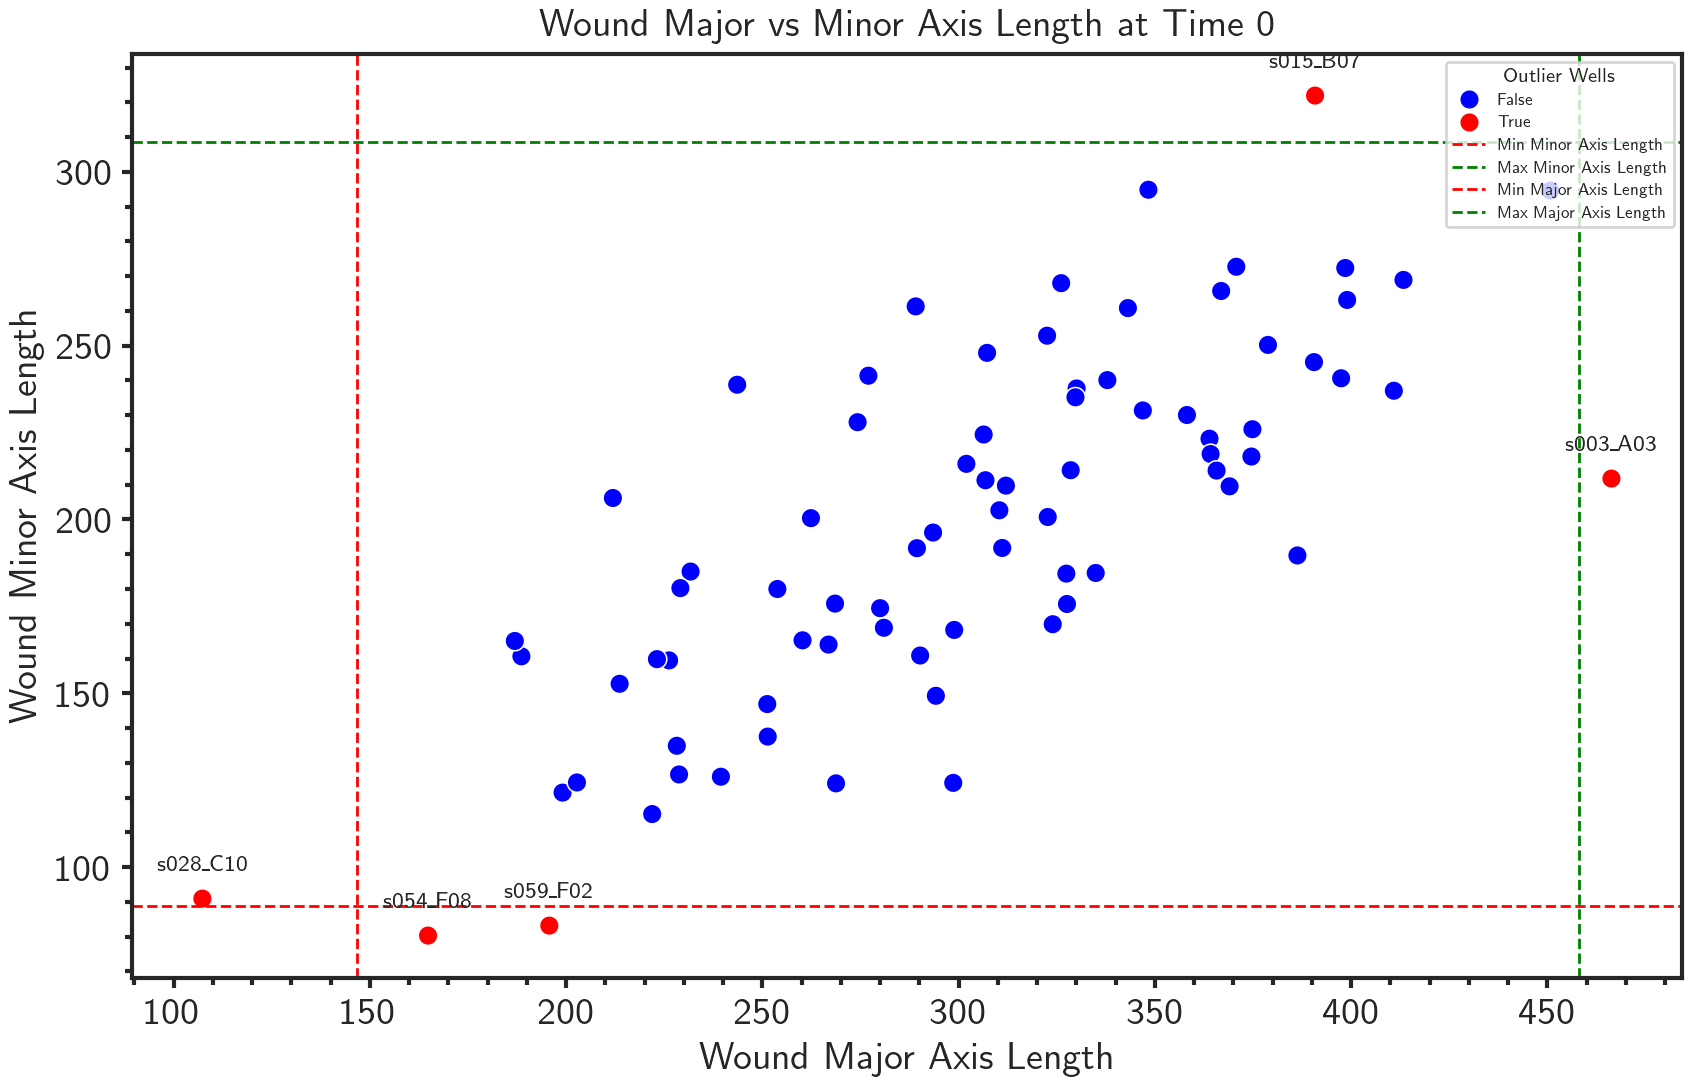

Finished processing R7P15_AI.xlsx.
Processing R7P21_AI.xlsx...
Processing file: Z:\Anish\Code Analyzed Data\20250706\R7P21_AI.xlsx
Columns dropped due to is_broken condition: ['s032_C11', 's061_F09', 's061_F09', 's072_G05', 's072_G05', 's076_G09']
Columns dropped due to is_closed[0]=0 condition: ['s034_D12', 's044_D02']
Dropped
['s032_C11', 's061_F09', 's061_F09', 's072_G05', 's072_G05', 's076_G09', 's034_D12', 's044_D02']
Dropping columns from other parameters
Wells outside bounds for R7P21_AI: 
['s004_A04', 's011_B11', 's018_B04', 's026_C05', 's033_C12', 's052_E07', 's055_E10', 's057_E12', 's058_F12', 's071_G04', 's073_G06', 's088_H04', 's090_H01']


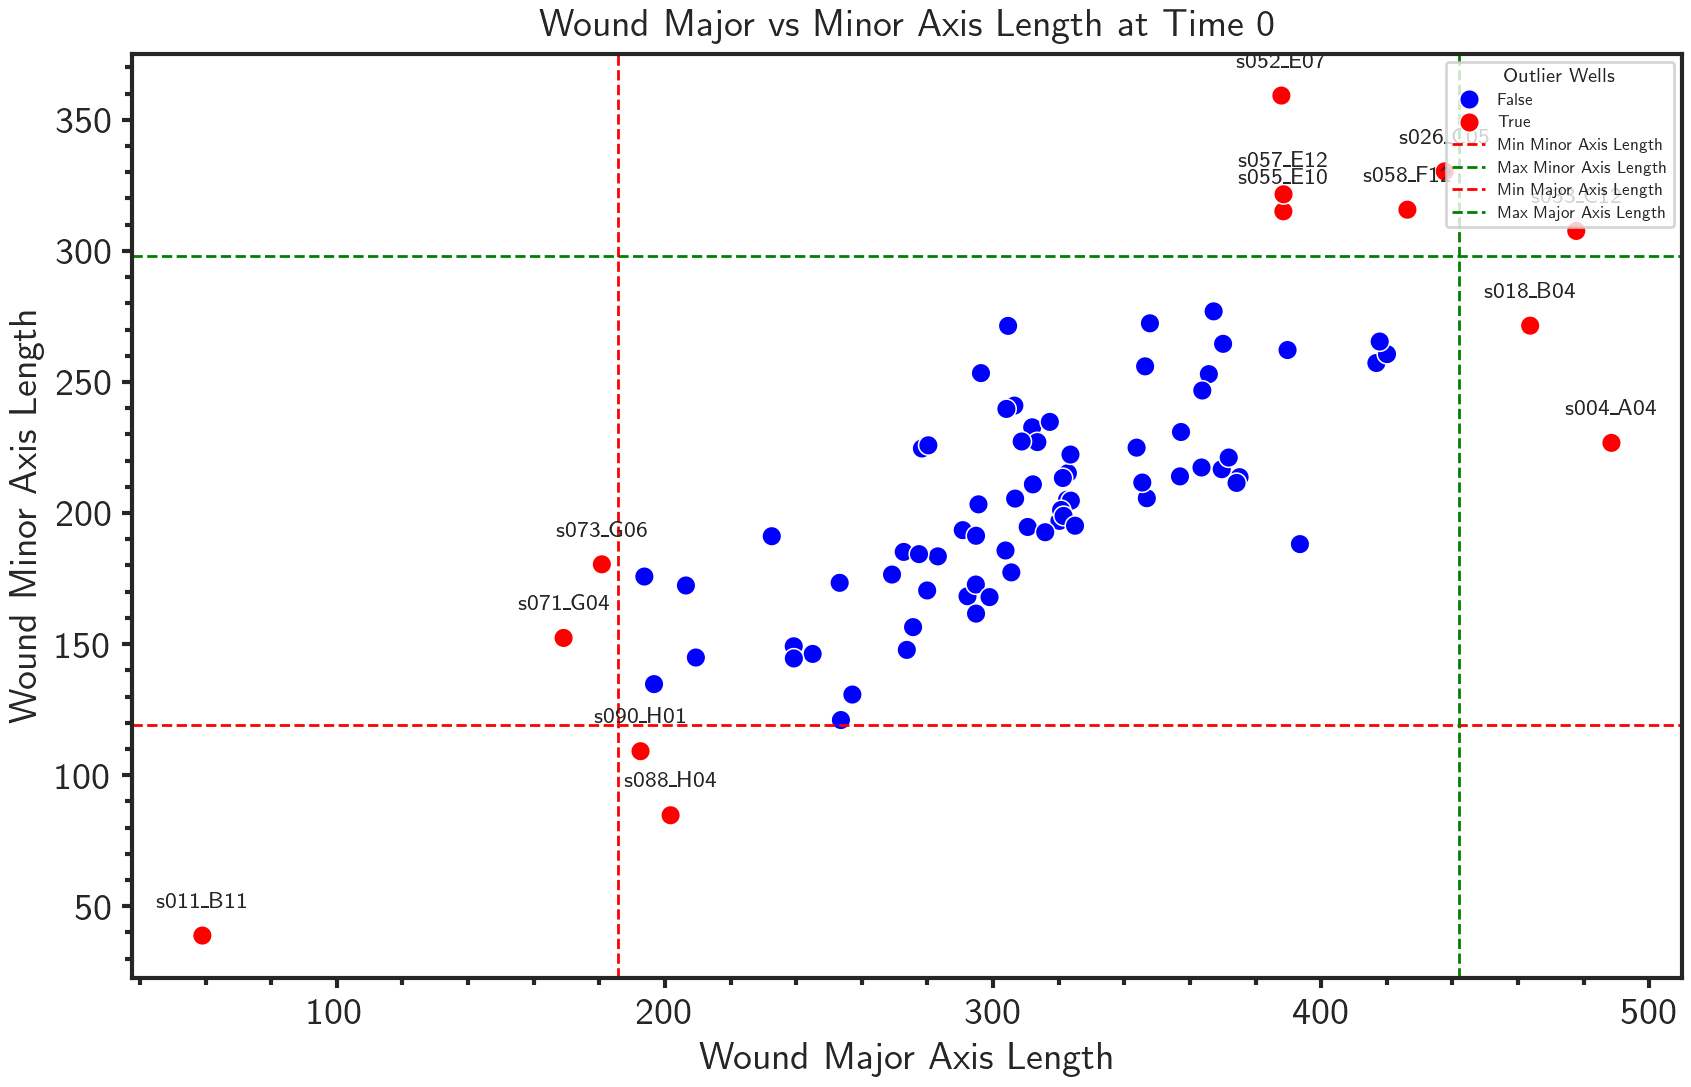

Finished processing R7P21_AI.xlsx.


In [31]:
# Create full file paths
file_paths = [os.path.join(dir_parent, file_name) for file_name in file_names]
print("Filenames to process:", file_names)

#Store extracted data in a dictionary addressable by file_name in file_names
extracted_data = {}
for file_name, file_path in zip(file_names, file_paths):
    print(f"Processing {file_name}...")
    extracted_data[file_name.split('.')[0]] = process_excel_files(file_name.split('.')[0],file_path)
    print(f"Finished processing {file_name}.")

Plotting outlier wells for R7P15_AI: ['s003_A03', 's015_B07', 's028_C10', 's054_F08', 's059_F02']


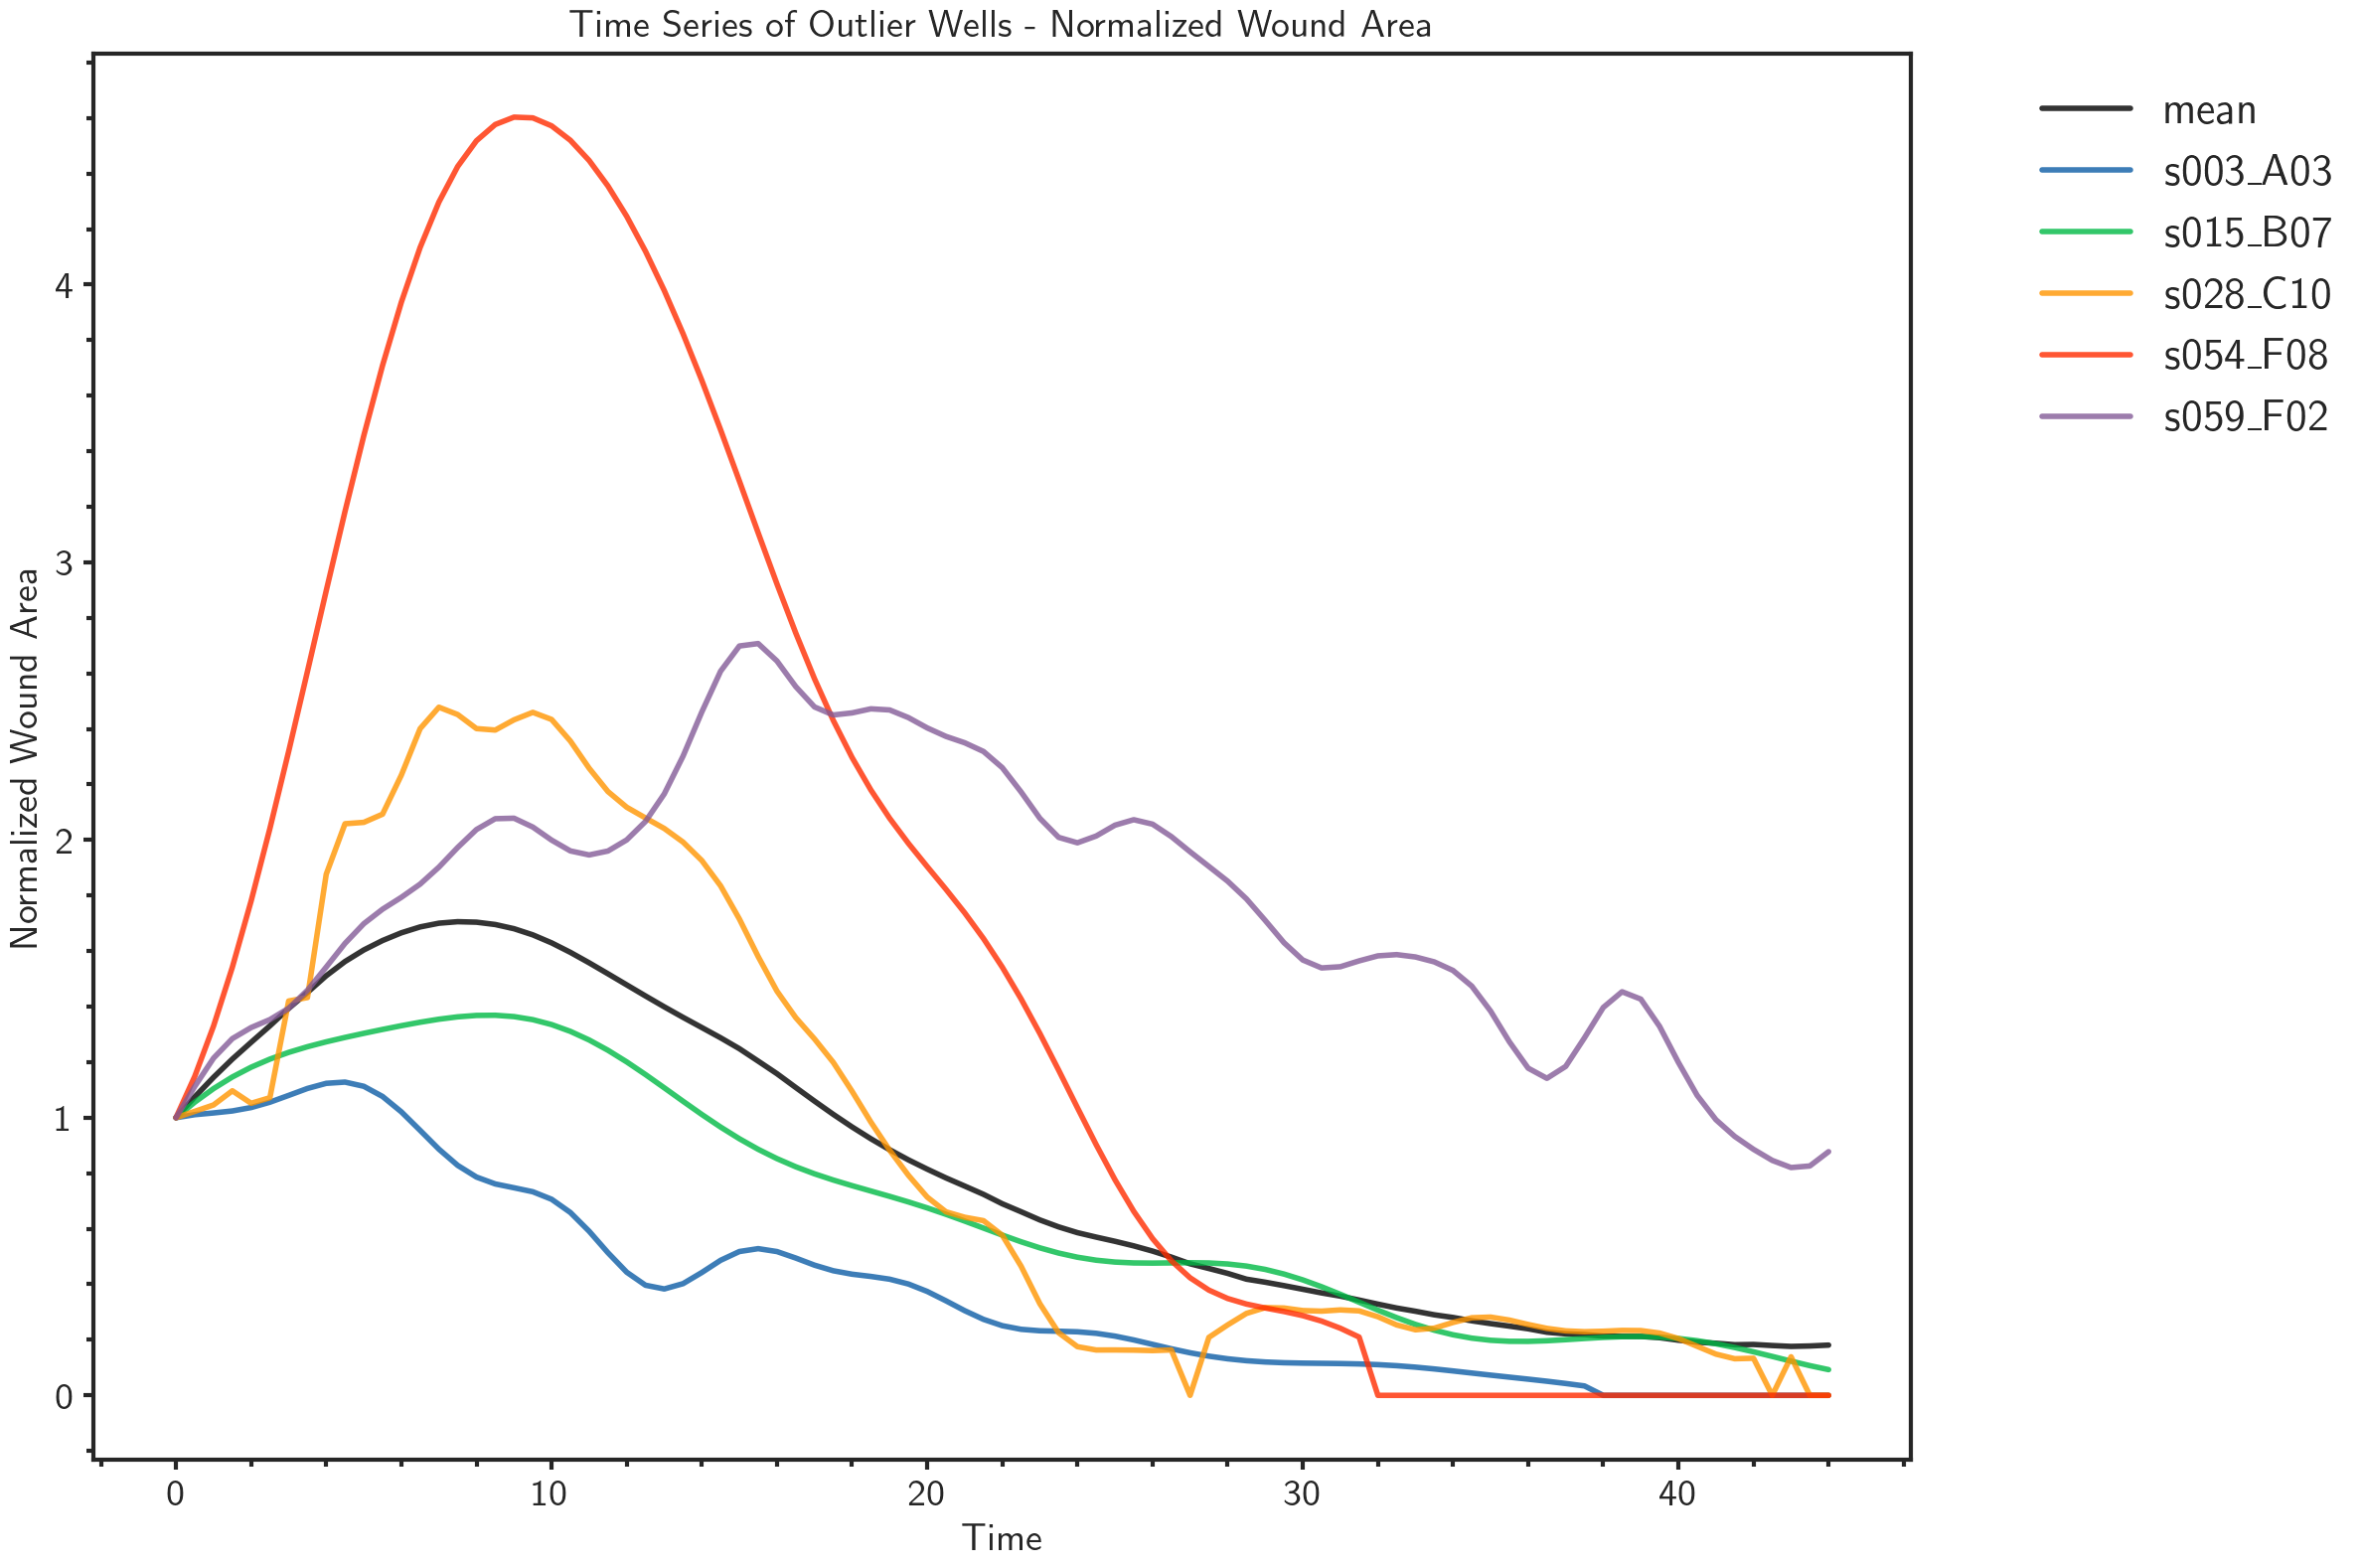

Plotting outlier wells for R7P21_AI: ['s004_A04', 's011_B11', 's018_B04', 's026_C05', 's033_C12', 's052_E07', 's055_E10', 's057_E12', 's058_F12', 's071_G04', 's073_G06', 's088_H04', 's090_H01']


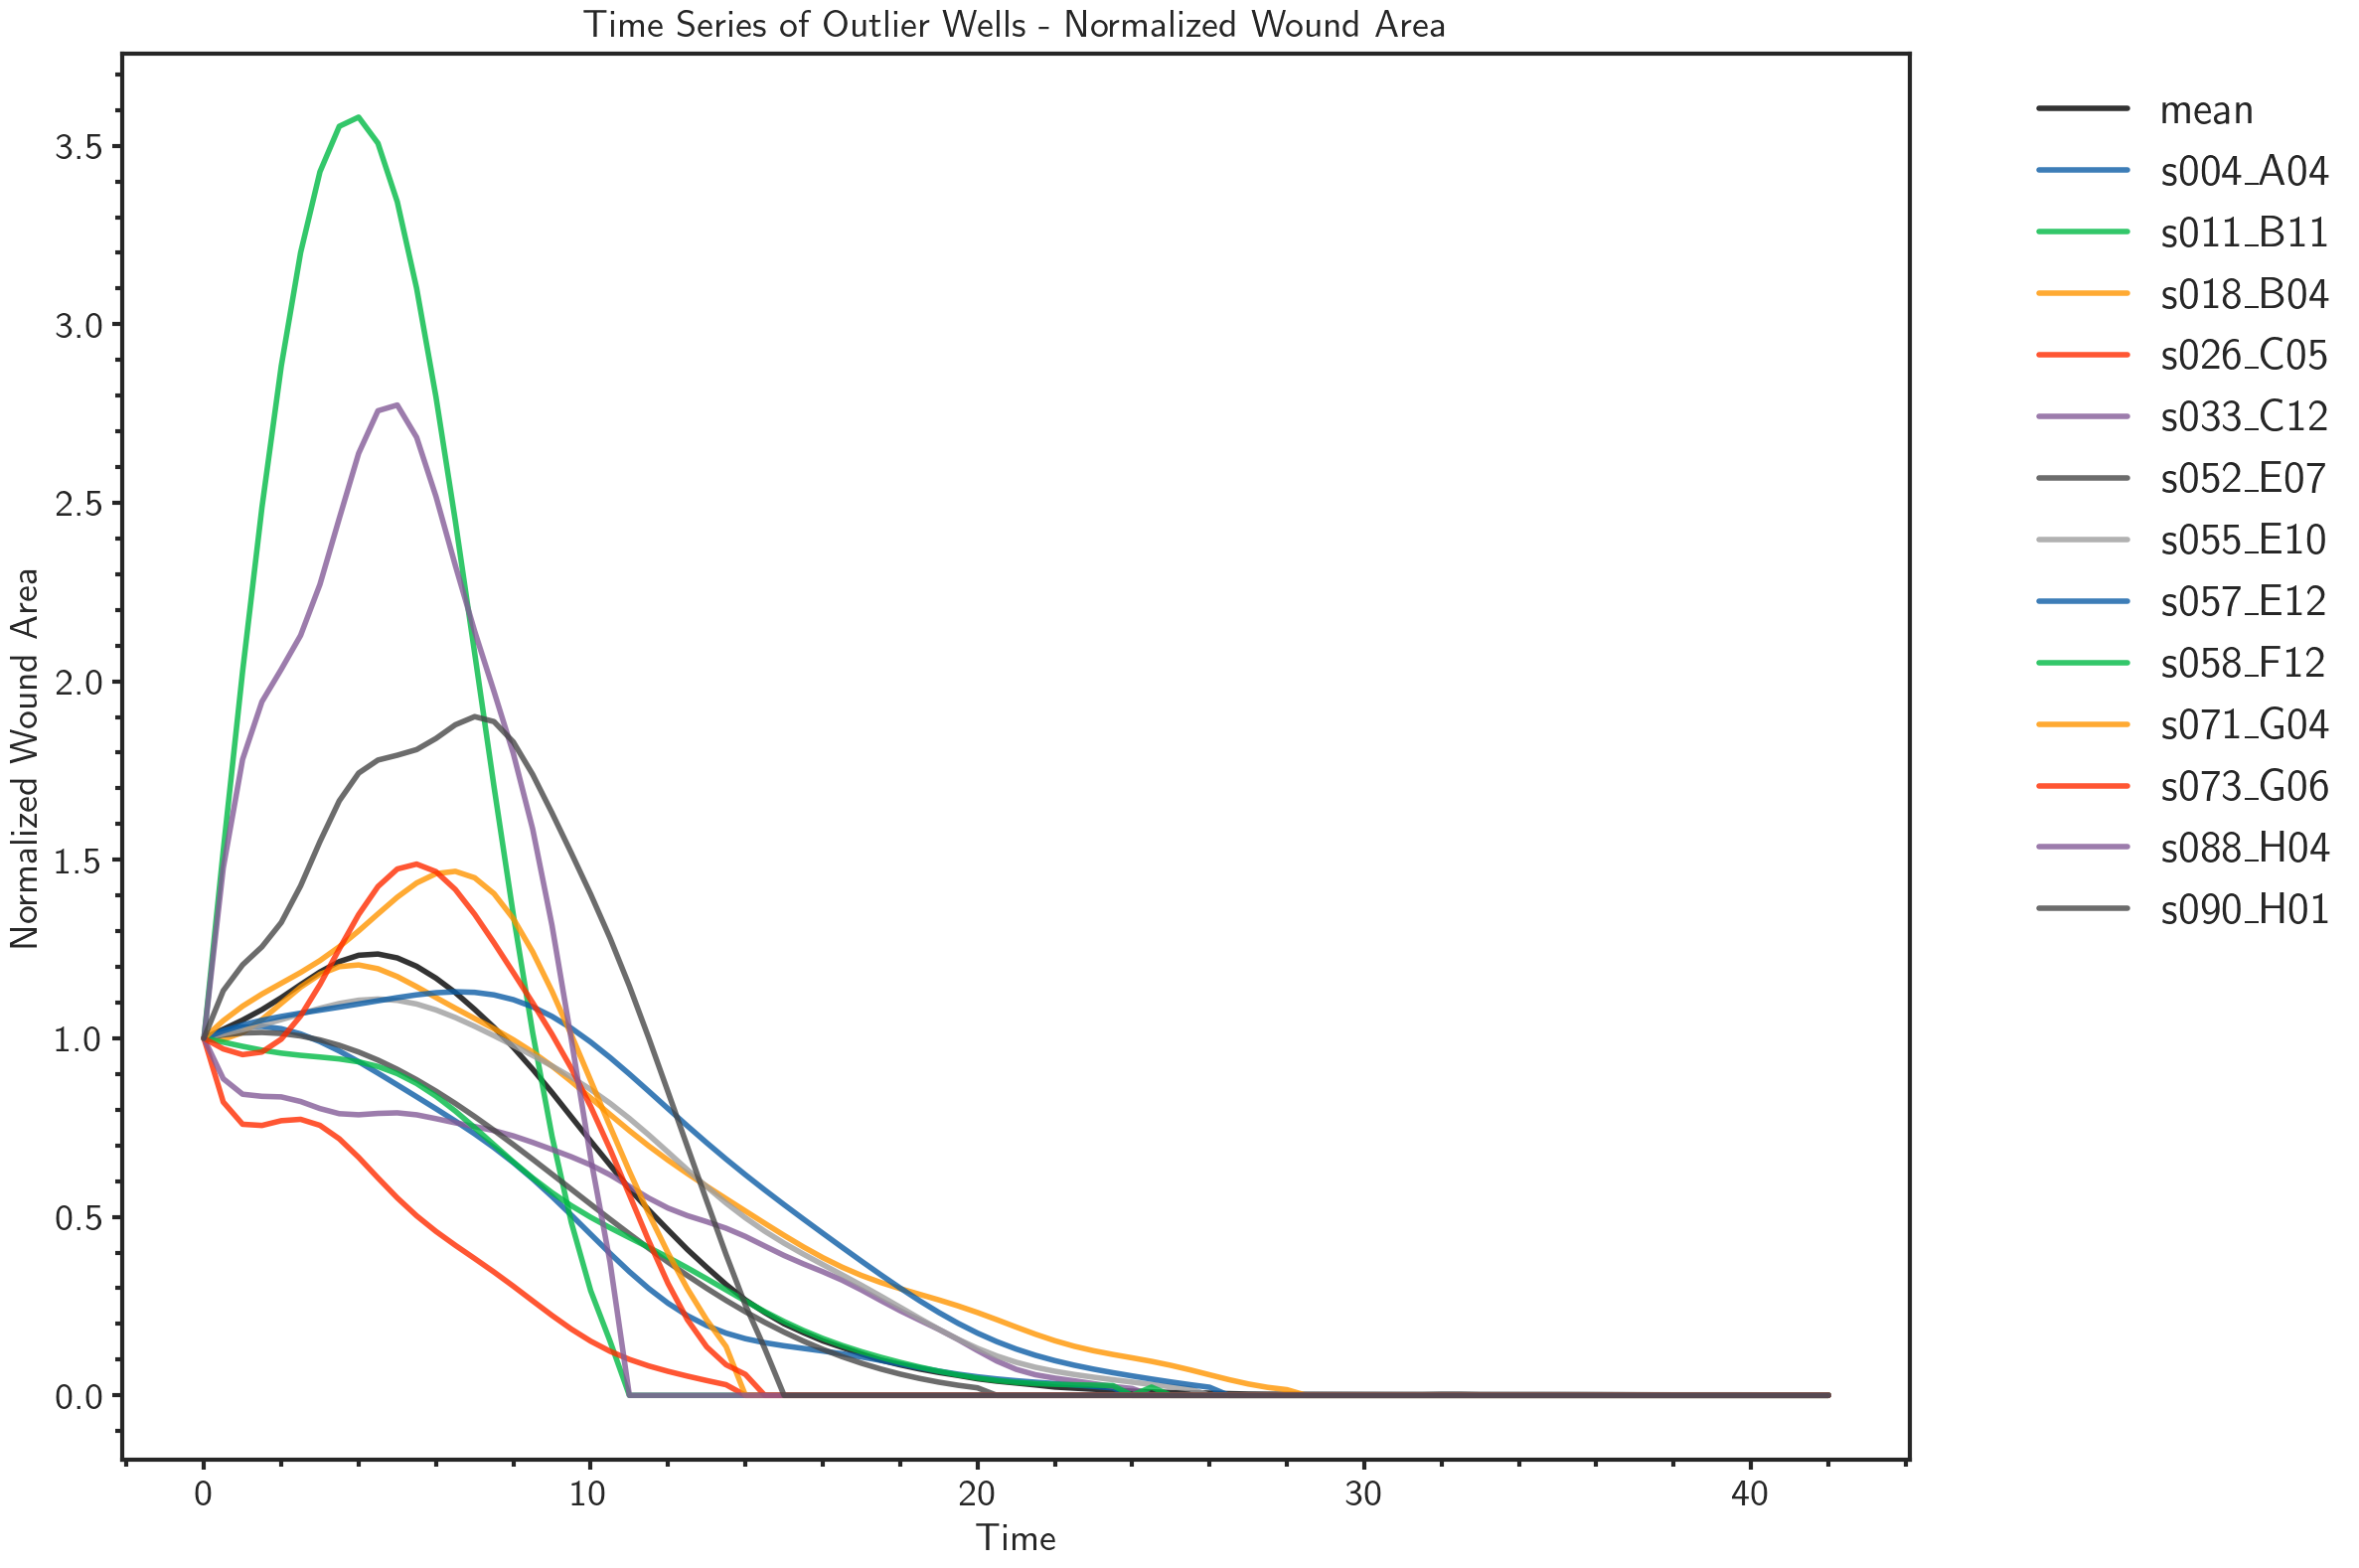

In [32]:
# Plot the time series for the outlier wells with a maximum of 5 lines per plot. If there are more than 5 outlier wells, it will create multiple plots.

for file_name, data in extracted_data.items():
    outlier_wells = data['outlier_wells']
    wound_area_normalized = data['wound_area_normalized']
    time_index = data['time_index']

    if outlier_wells:
        print(f"Plotting outlier wells for {file_name}: {list(outlier_wells.keys())}")
        plt.figure(figsize=(12, 8))
        plt.plot(time_index, wound_area_normalized.mean(axis=1), label='mean', color='black', linewidth=2, alpha=0.8)
        for well_name in outlier_wells.keys():
            # Find the full column name in wound_area_normalized that matches the outlier well
            matching_columns = [col for col in wound_area_normalized.columns if well_name in col]

            if matching_columns:
                well_column = matching_columns[0]

                plt.plot(time_index, wound_area_normalized[well_column],
                        label=f"{well_name}", linewidth=2, alpha=0.8)

        plt.xlabel('Time')
        plt.ylabel('Normalized Wound Area')
        plt.title('Time Series of Outlier Wells - Normalized Wound Area')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        #plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{file_name}_outlier_wells_timeseries.svg', format='svg', dpi=600, bbox_inches='tight')
        plt.show()





In [33]:
# Drop all outlier wells from the wound_area_normalized DataFrame
for file_name, data in extracted_data.items():
    outlier_wells = data['outlier_wells']
    wound_area_normalized = data['wound_area_normalized']
    if outlier_wells:
        print(f"Dropping outlier wells for {file_name}: {list(outlier_wells.keys())}")
        # Create a list of columns to drop
        columns_to_drop = [col for col in wound_area_normalized.columns if any(well in col for well in outlier_wells.keys())]
        # Drop the columns from the DataFrame
        wound_area_normalized.drop(columns=columns_to_drop, inplace=True)
        extracted_data[file_name]['wound_area_normalized'] = wound_area_normalized

        #Drop the outlier wells from the wound_minor_axis_length and wound_major_axis_length DataFrames and from the dict_condition
        wound_minor_axis_length = data['wound_minor_axis_length']
        wound_major_axis_length = data['wound_major_axis_length']
        for col in columns_to_drop:
            if col in wound_minor_axis_length.columns:
                wound_minor_axis_length.drop(columns=col, inplace=True)
            if col in wound_major_axis_length.columns:
                wound_major_axis_length.drop(columns=col, inplace=True)
        extracted_data[file_name]['wound_minor_axis_length'] = wound_minor_axis_length
        extracted_data[file_name]['wound_major_axis_length'] = wound_major_axis_length
        # Drop the outlier wells from the dict_condition
        dict_condition = data['dict_condition']
        for condition, wells in dict_condition.items():
            dict_condition[condition] = [well for well in wells if well not in columns_to_drop]
        extracted_data[file_name]['dict_condition'] = dict_condition

Dropping outlier wells for R7P15_AI: ['s003_A03', 's015_B07', 's028_C10', 's054_F08', 's059_F02']
Dropping outlier wells for R7P21_AI: ['s004_A04', 's011_B11', 's018_B04', 's026_C05', 's033_C12', 's052_E07', 's055_E10', 's057_E12', 's058_F12', 's071_G04', 's073_G06', 's088_H04', 's090_H01']


### Reshape Data to human readable format and long format for plotting

#### Human Readable Format

In [34]:
# Make a combined dataset of all the conditions in the extracted_data dictionary.
dict_combined_conditions, combined_conditions_counts = combine_conditions(extracted_data)

In [35]:
#Drop unnecessary conditions
conditions_to_drop = ['bad device', 'seeding problem']

for condition in conditions_to_drop:
    # Use exact case-insensitive matching
    keys_to_remove = [key for key in dict_combined_conditions.keys() if key.lower() == condition.lower()]

    if keys_to_remove:
        for key_to_remove in keys_to_remove:
            print(f"Removing '{key_to_remove}' condition from combined conditions and extracted data...")
            del dict_combined_conditions[key_to_remove]
            combined_conditions_counts = combined_conditions_counts.drop(key_to_remove, axis=0)

Removing 'Seeding Problem' condition from combined conditions and extracted data...


#### Long Format for Plotting

In [36]:
# Find the shortest time index in the extracted_data dictionary
# This is to ensure that the reshaped data has the same time index as the original data
# Return the key with the shortest time index
shortest_time_index = min(extracted_data.keys(), key=lambda k: len(extracted_data[k]['time_index']))
# Reshape the combined condition dictionary
reshaped_data = reshape_combined_conditions(extracted_data, extracted_data[shortest_time_index]['time_index'])

### Plot Time Series Data

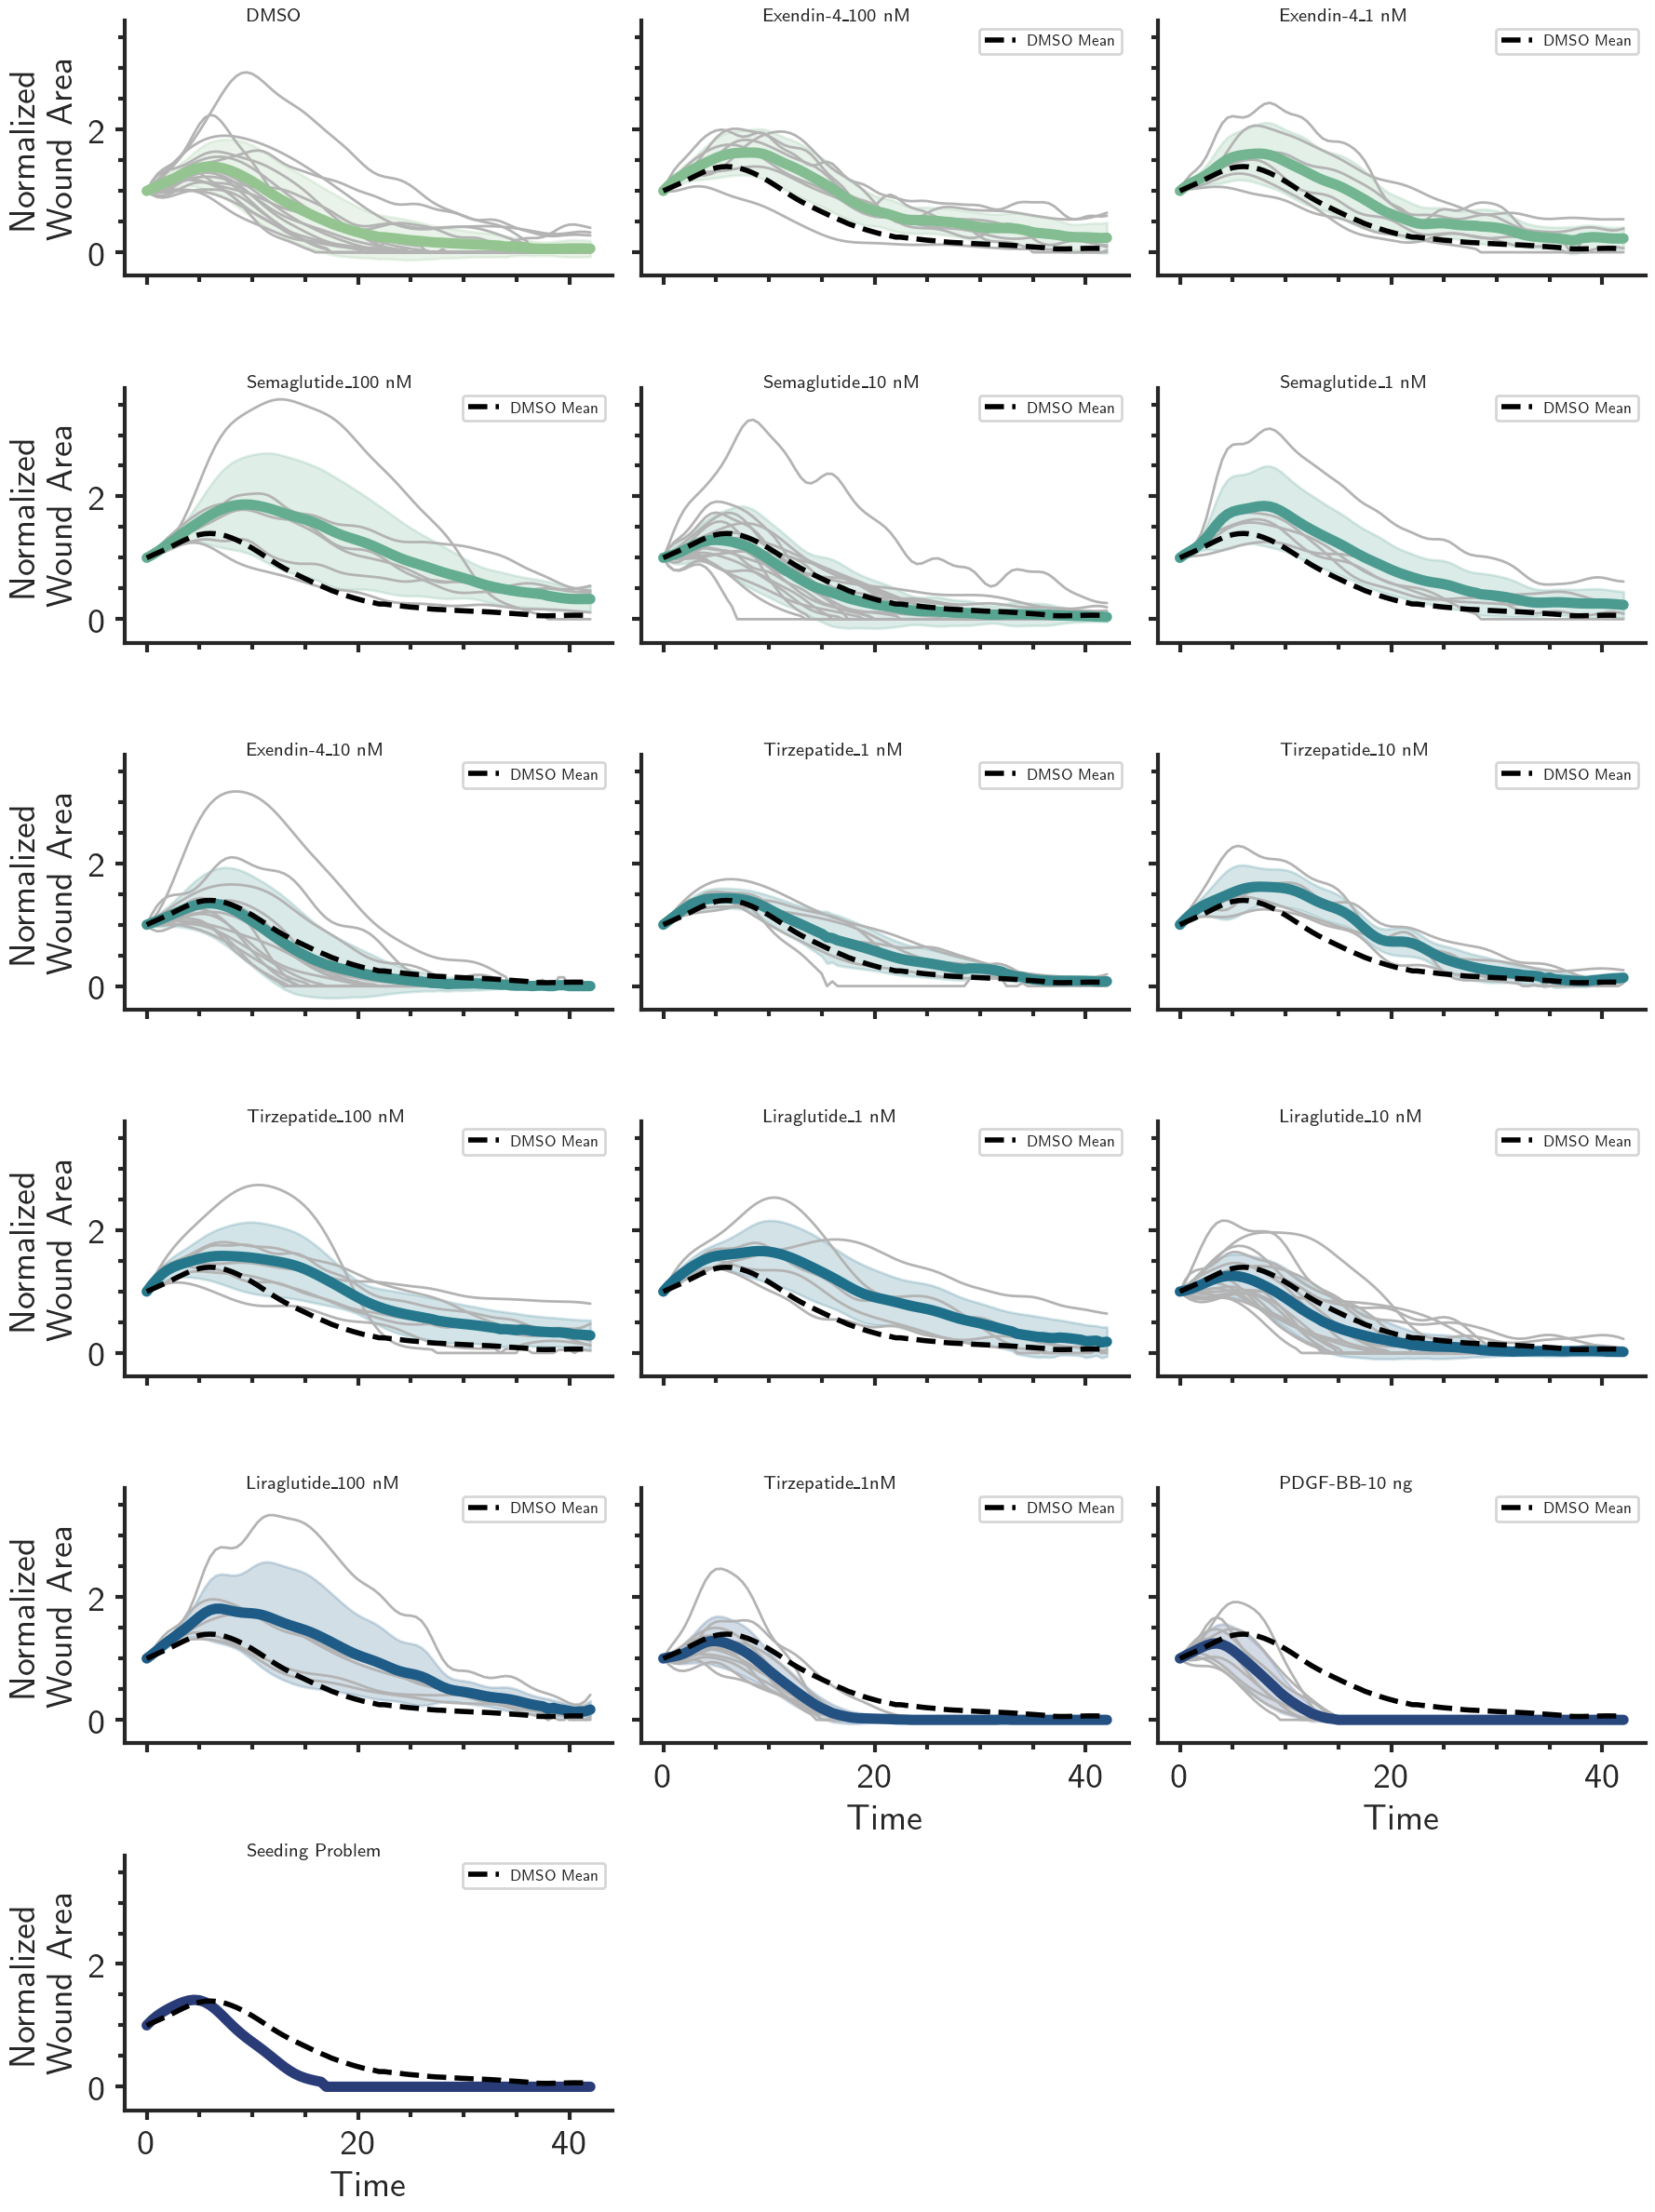

In [37]:
# Plotting the time series data using seaborn
# Plot average time series with individual wells in lighter color
g = sns.relplot(
    data=reshaped_data,
    x="time_index", y="wound_area_normalized", col="condition_map", hue="condition_map",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,errorbar = "sd"
)

# Calculate the mean wound area for the control group to plot as a reference line
mean_control_group = reshaped_data[reshaped_data['condition_map'] == control_group_name].groupby('time_index')['wound_area_normalized'].mean().reset_index()

# Iterate over each subplot to customize further
for condition, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(0.25, 1, condition, transform=ax.transAxes, fontweight="bold")

    # Filter data for only the current condition
    condition_data = reshaped_data[reshaped_data['condition_map'] == condition]
    # Plot every condition's time series in the background. Color code them according to the experiment they belong to (exp)
    # sns.lineplot( data=condition_data, x='time_index', y='wound_area', units='exp', alpha=0.5, legend=False, ax=ax, zorder=1)

    sns.lineplot(
        data=condition_data, x='time_index', y='wound_area_normalized', units='well', estimator=None, color='0.7', legend=False, ax=ax, zorder=1
    )

    # Plot DMSO mean line (skip if current condition is DMSO itself)
    if condition != 'DMSO':
        #print('Plotting DMSO mean line for condition:', condition)
        ax.plot(mean_control_group['time_index'], mean_control_group['wound_area_normalized'], color='black', linewidth=2, linestyle='--', alpha=1, label='DMSO Mean',zorder=20)
        # Add a legend for the DMSO mean line
        ax.legend(loc='upper right', fontsize='small',
                  title_fontsize='medium', frameon=True, shadow=False, fancybox=True)

# Set labels and layout
g.set_titles("")
g.set_axis_labels("Time", "Normalized \n Wound Area")

plt.savefig('average_plot_with_std_seaborn.svg', dpi=600)
g.tight_layout()

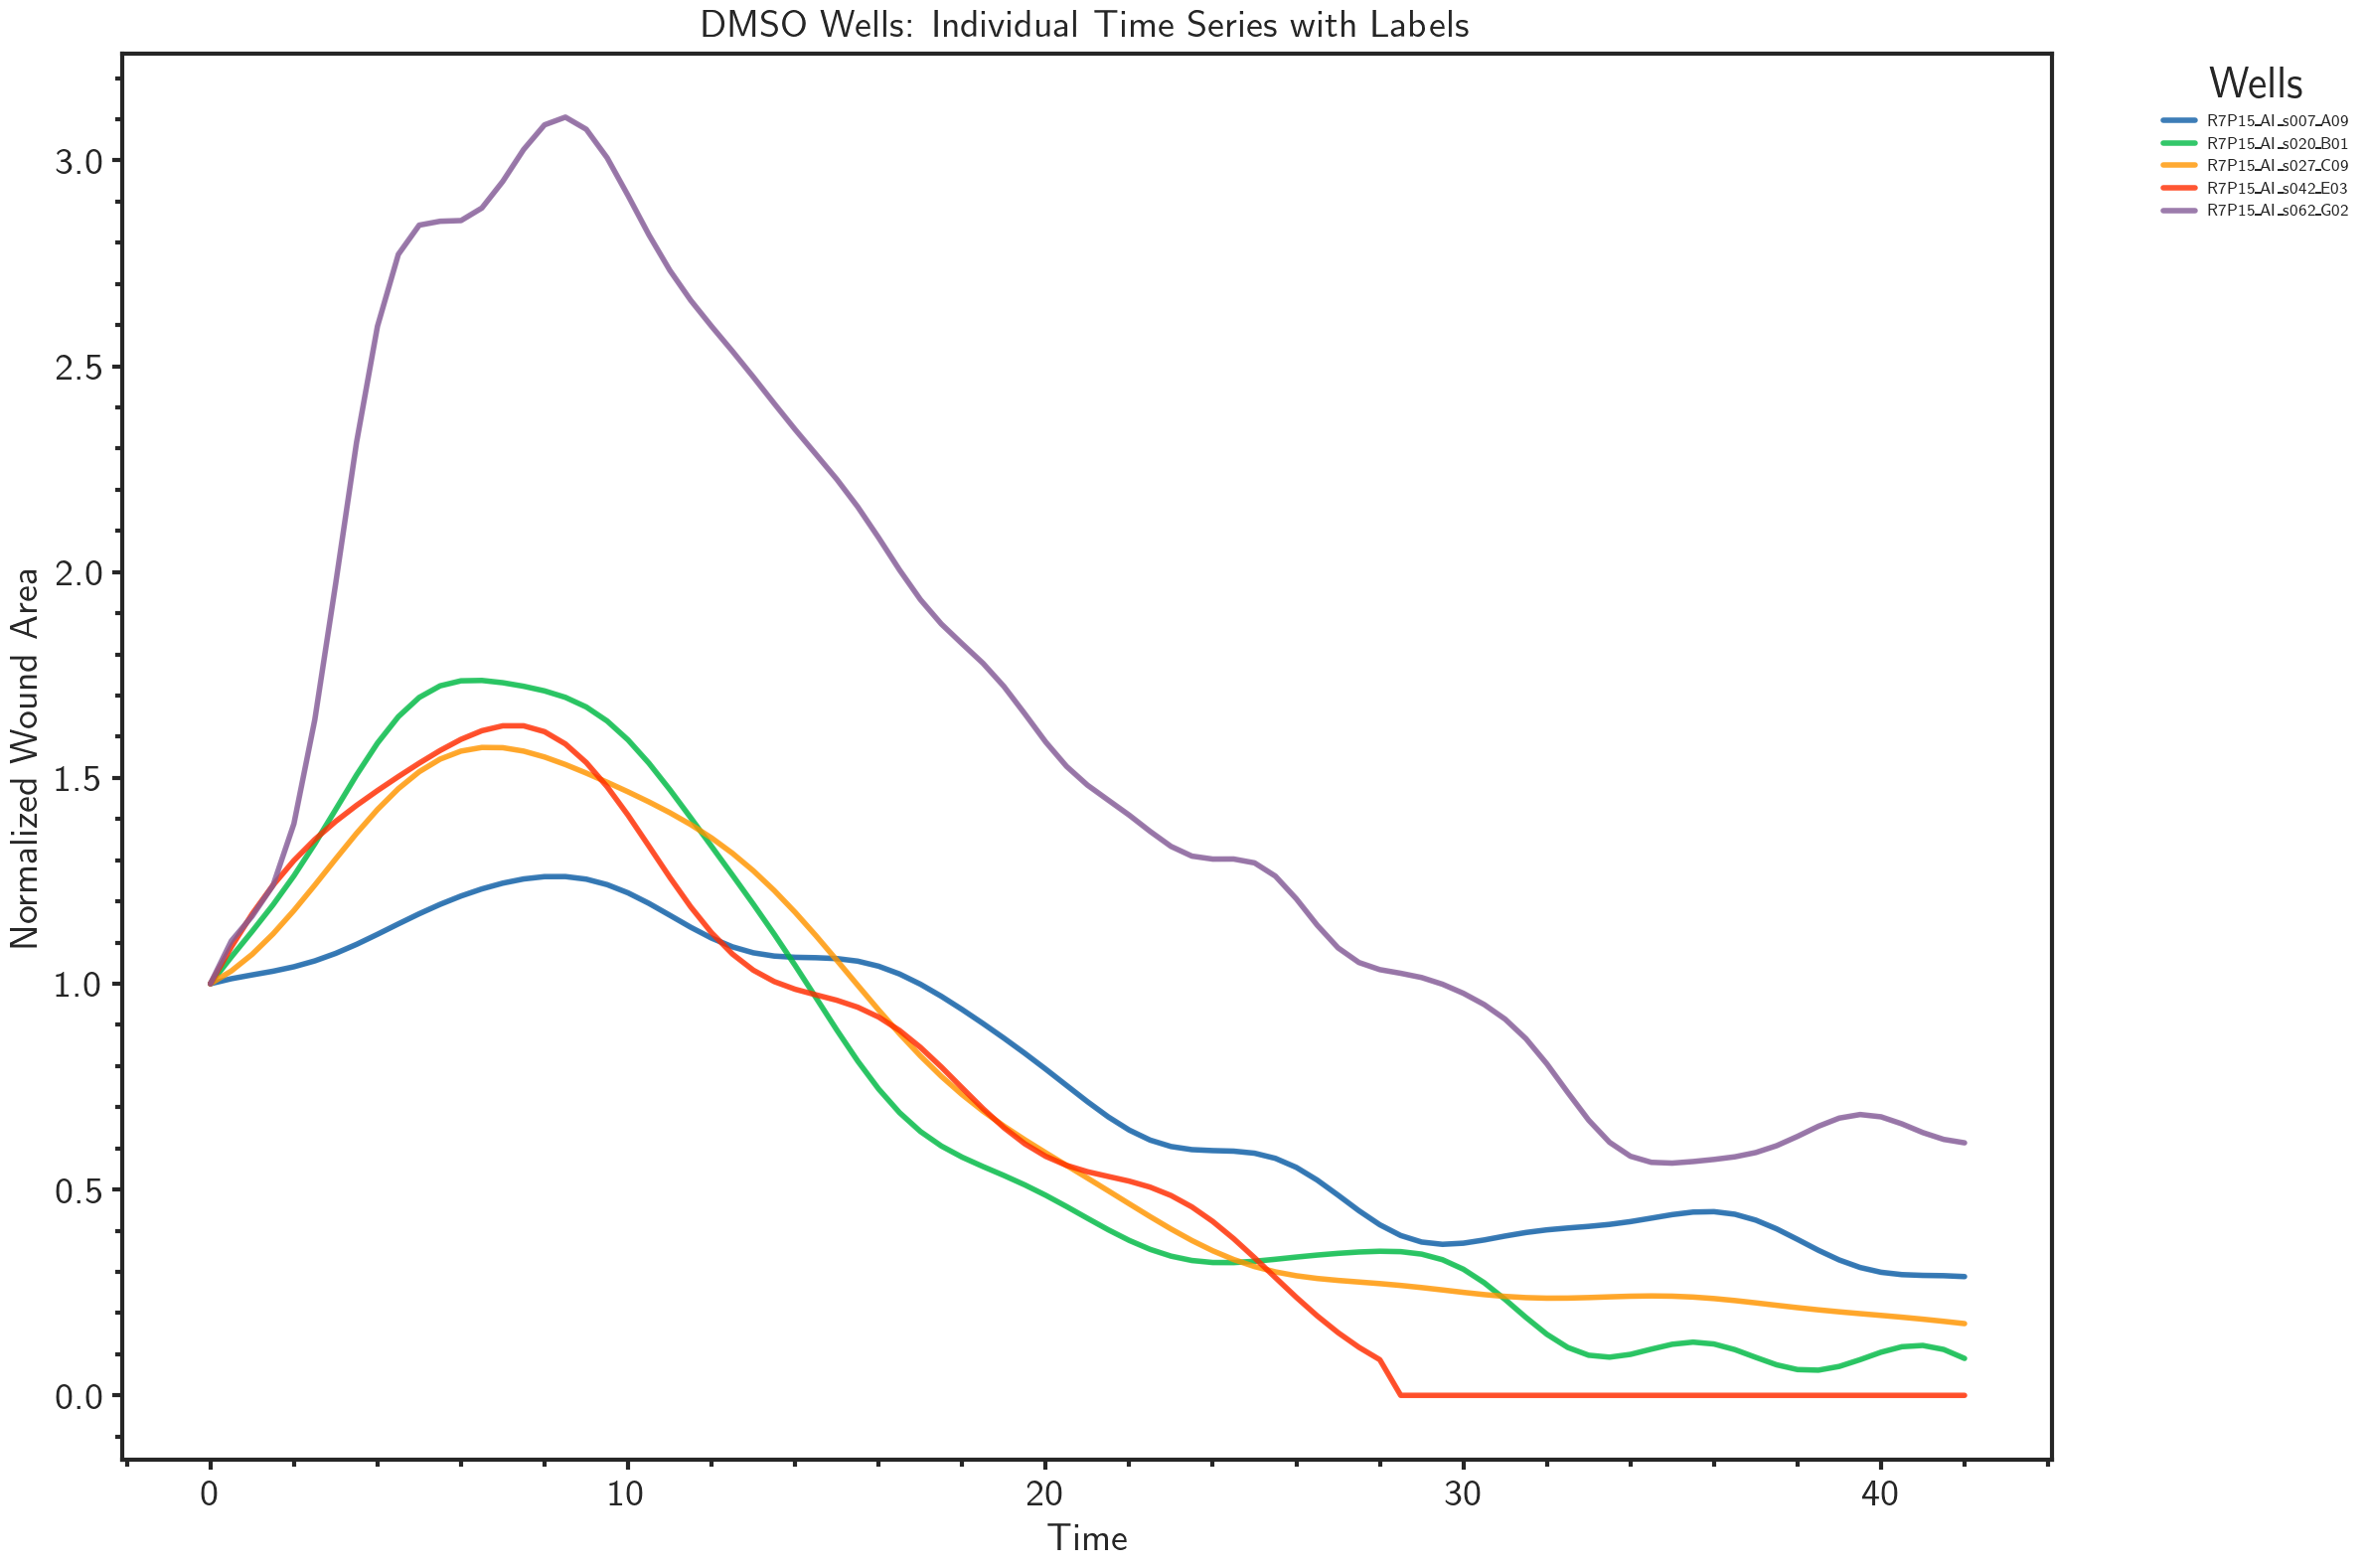

In [38]:
# Plot DMSO lines with individual wells labelled using seaborn
dmso_data = reshaped_data[reshaped_data['condition_map'] == 'Semaglutide_1 nM']

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=dmso_data,
    x='time_index',
    y='wound_area_normalized',
    hue='well',
    linewidth=2,
    alpha=0.8
)

plt.xlabel('Time')
plt.ylabel('Normalized Wound Area')
plt.title('DMSO Wells: Individual Time Series with Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title='Wells')
plt.tight_layout()
plt.savefig('dmso_wells_labeled_seaborn.svg', dpi=600)
plt.show()

In [39]:
#Plot area under the curve for each condition by calculating the area under the curve for each individual well and then averaging across wells for each condition. Plot the mean and standard deviation of the area under the curve for each condition.
def calculate_auc(data):
    """Calculate the area under the curve for each well."""
    return data.apply(lambda x: np.trapz(x), axis=0)
# Calculate AUC for each well
auc_data = reshaped_data.groupby('condition_map').apply(lambda x: calculate_auc(x.pivot(index='time_index', columns='well', values='wound_area_normalized')))
# Calculate mean and standard deviation of AUC for each condition
auc_mean = auc_data.groupby('condition_map').mean()
auc_std = auc_data.groupby('condition_map').std()

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
# Plot AUC for each condition
plt.figure(figsize=(10, 6))
sns.barplot(x=auc_mean.index, y=auc_mean.values.flatten(), palette='crest', capsize=0.1)
plt.errorbar(
    x=auc_mean.index, y=auc_mean.values.flatten(),
    yerr=auc_std.values.flatten(), fmt='none', color='black', capsize=5, elinewidth=1
)

plt.title('Area Under the Curve (AUC) for Each Condition')
plt.xlabel('Condition')
plt.ylabel('AUC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('auc_plot.svg', dpi=600)
plt.show()

In [ ]:
# Plot full width half maximum (FWHM) for each condition. Calculate FWHM for each well and then average across wells for each condition. Plot the mean and standard deviation of the FWHM for each condition.
def calculate_fwhm(data):
    """Calculate the full width half maximum for each well."""
    fwhm_values = []
    for col in data.columns:
        y = data[col]
        half_max = y.max() / 2
        indices = np.where(y >= half_max)[0]
        if len(indices) > 0:
            fwhm = indices[-1] - indices[0]
            fwhm_values.append(fwhm)
        else:
            fwhm_values.append(np.nan)  # If no indices found, append NaN
    return pd.Series(fwhm_values, index=data.columns)

In [ ]:
# Calculate FWHM for each well and store in long-format DataFrame
fwhm_long_data = []
for condition, group in reshaped_data.groupby('condition_map'):
    fwhm_values = calculate_fwhm(group.pivot(index='time_index', columns='well', values='wound_area'))
    for well, fwhm in fwhm_values.items():
        fwhm_long_data.append({
            'condition_map': condition,
            'well': well,
            'fwhm': fwhm
        })
fwhm_long_df = pd.DataFrame(fwhm_long_data)

In [ ]:
# Plot FWHM for each condition. PLot as a violin plot with individual data points (staggered).
plt.figure(figsize=(10, 6))
sns.violinplot(x='condition_map', y='fwhm', data=fwhm_long_df, inner='quart', color='lightblue', linewidth=1.25)
sns.swarmplot(x='condition_map', y='fwhm', data=fwhm_long_df, color='black', alpha=0.7)
plt.title('Full Width Half Maximum (FWHM) for Each Condition')
plt.xlabel('Condition')
plt.ylabel('FWHM')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('fwhm_plot.svg', dpi=600)
plt.show()

In [ ]:
# Histogram of relative_pillar_distances at time 0. Do not group by condition, just plot all wells together.

relative_pillar_distances = extracted_data['R7P21_AI']['relative_pillar_distances'][0]
# Reshape the DataFrame to long format for seaborn
relative_pillar_distances_long = relative_pillar_distances.melt(var_name='Pillar', value_name='Distance')
# Filter out NaN values
relative_pillar_distances_long = relative_pillar_distances_long.dropna(subset=['Distance'])
# Plot histogram of relative pillar distances
plt.figure(figsize=(10, 6))
sns.histplot(data=relative_pillar_distances_long, x='Distance', hue='Pillar', multiple='stack', kde=False, bins=30, palette='crest', alpha=0.7)
plt.title('Histogram of Relative Pillar Distances at Time 0')
plt.xlabel('Relative Pillar Distance')
plt.ylabel('Frequency')
# plt.legend(title='Pillar', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('relative_pillar_distances_histogram.svg', dpi=600)
plt.show()

## Test Code

In [49]:
wan = data_fn['wound_area_normalized'][:len(time_index_input)].copy()
wan.index = time_index_input
waf = data_fn['wound_area_filtered'][:len(time_index_input)].copy()
waf.index = time_index_input
combined_wound_areas = pd.concat(
    [wan, waf],
    axis=1,
    keys=['wound_area_normalized', 'wound_area_pixels']
)
long_wound_areas = combined_wound_areas.stack(level=1,future_stack=True).reset_index()
long_wound_areas.rename(columns={'level_1': 'well'}, inplace=True)

In [60]:
data_fn = extracted_data['R7P21_AI']
time_index_input =time_index
rpd_wide = data_fn['relative_pillar_distances'].iloc[:len(time_index_input)].copy()
rpd_wide.index = time_index_input
rpd_wide.columns.names = ['rpd_id', 'well']
rpd_wide.columns = rpd_wide.columns.set_levels([f'rpd_{i}' for i in rpd_wide.columns.get_level_values('rpd_id').unique()], level='rpd_id')
rpd_long = rpd_wide.stack(level=['well'], future_stack=True).reset_index()

In [58]:
print(rpd_wide.columns.levels[0])
print(rpd_wide.columns.levels(name='rpd_id'))

RangeIndex(start=0, stop=6, step=1, name='rpd_id')


TypeError: 'FrozenList' object is not callable